## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from model_classes import HealthModel
import torch
from datetime import datetime as dt

## Config

Linear regressor config:

In [87]:
config = {
    "architecture": "linear_regressor",
    "train_size": 0.8,
    "val_size": False, # Set MLP 
    "hidden_layer_sizes": False, # configs
    "batch_size": False, # to False
    "num_epochs": False, # if using
    "learning_rate": False, # linear regressor
    "species": "NO2",
    "spatial_resolution": "regional",
    "temporal_resolution": "daily",
    "input_artifacts": ["laqn-regional", "met-resample", "income-regional"],
    "laqn_variables": ["NO2", "PM10"], # Set to False if excluding air pollutants
    "met_variables": ["temperature", "humidity", "dew_point", "wind_speed", "pressure"], # "wind_dir"# Set to False if excluding meteorology
    "income_variables": ["gross_disposable_income", "property_income_received", #"property_income_paid", 
                         "social_benefits_received", "current_taxes_on_wealth"], # Set to False if excluding income
    "ablation_features": False, #["temperature"] # Set to False if not analysing feature importance
    "target_shift": 1, # Time lag end point for target variable
    "window_size": 7 # Input window size
    }

MLP regressor config:

In [117]:
config = {
    "architecture": "MLP_regressor",
    "train_size": 0.7,
    "val_size": 0.15, # Set MLP configs
    "hidden_layer_sizes": [10],
    "batch_size": 30, # to False
    "num_epochs": 100, # if using
    "learning_rate": 0.001, # linear regressor
    "species": "NO2",
    "spatial_resolution": "regional",
    "temporal_resolution": "daily",
    "input_artifacts": ["laqn-regional", "met-resample", "income-regional"],
    "laqn_variables": ["NO2", "PM10"], # Set to False if excluding air pollutants
    "met_variables": ["temperature", "humidity", "dew_point", "wind_speed", "pressure"], # "wind_dir" # Set to False if excluding meteorology
    "income_variables": ["gross_disposable_income", "property_income_received", "social_benefits_received", "current_taxes_on_wealth"], # Set to False if excluding income
    "ablation_features": ["gross_disposable_income", "property_income_received", "social_benefits_received", "current_taxes_on_wealth"], # Set to False if not analysing feature importance
    "target_shift": 1, # Time lag for target variable
    "window_size": 1 # Input window size
    }

torch.manual_seed(1)

In [118]:
if not config["ablation_features"]:
    plot_title_model = f"(all inputs, time lag {config['target_shift']} window {config['window_size']})"
else:
    plot_title_model = f"(scrambled {', '.join(config['ablation_features'])}, time lag {config['target_shift']} window {config['window_size']})"

## Code

In [119]:
model = HealthModel(config)

In [120]:
inputs, targets, datetime = model.preprocess_and_log()

laqn-regional


wandb:   6 of 6 files downloaded.  


met-resample


wandb:   8 of 8 files downloaded.  


income-regional


wandb:   51 of 51 files downloaded.  


input columns:  Index(['NO2_mean', 'NO2_min', 'NO2_max', 'PM10_mean', 'PM10_max', 'PM10_min',
       'temperature_mean', 'temperature_min', 'temperature_max',
       'humidity_mean', 'humidity_min', 'humidity_max', 'dew_point_mean',
       'dew_point_min', 'dew_point_max', 'wind_speed_mean', 'wind_speed_min',
       'wind_speed_max', 'pressure_mean', 'pressure_min', 'pressure_max',
       'gross_disposable_income_min', 'gross_disposable_income_median',
       'gross_disposable_income_max', 'property_income_received_max',
       'property_income_received_median', 'property_income_received_min',
       'social_benefits_received_median', 'social_benefits_received_max',
       'social_benefits_received_min', 'current_taxes_on_wealth_median',
       'current_taxes_on_wealth_max', 'current_taxes_on_wealth_min'],
      dtype='object')
Ablation - scrambled columns: ['gross_disposable_income_min', 'gross_disposable_income_median', 'gross_disposable_income_max', 'property_income_received_max', '

wandb:   1 of 1 files downloaded.  



 train
inputs (5363, 33)
targets (5363,)
datetime index (5363,)
Processing time lagged (1) input windows (length 1)
inputs (before flattening) (5362, 1, 33)
targets (before flattening) (5362, 1)
datetime index (5362,)

 val
inputs (1149, 33)
targets (1149,)
datetime index (1149,)
Processing time lagged (1) input windows (length 1)
inputs (before flattening) (1148, 1, 33)
targets (before flattening) (1148, 1)
datetime index (1148,)

 test
inputs (1150, 33)
targets (1150,)
datetime index (1150,)
Processing time lagged (1) input windows (length 1)
inputs (before flattening) (1149, 1, 33)
targets (before flattening) (1149, 1)
datetime index (1149,)


In [2]:
model.create_baseline()

NameError: name 'model' is not defined

In [6]:
model.train_and_log()

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


x_train shape (5362, 33)
hidden layer sizes [33, 10]


100%|██████████| 100/100 [00:26<00:00,  3.78it/s]


best_epoch,▁
best_mean_absolute_percentage_error_train,▁
best_mean_absolute_percentage_error_val,▁
best_mean_squared_error_train,▁
best_mean_squared_error_val,▁
best_r_squared_train,▁
best_r_squared_val,▁
best_rmse_train,▁
best_rmse_val,▁
best_smape_train,▁
best_smape_val,▁


In [121]:
data_dict = model.test_and_log()

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


mean_absolute_percentage_error_test,▁
mean_squared_error_test,▁
r2_test,▁
rmse_test,▁
smape_test,▁
mean_absolute_percentage_error_test,22.62253
mean_squared_error_test,0.14131
r2_test,-1.45977
rmse_test,0.37591
smape_test,19.67918


#### Alternative
If the model has already been run, lookup the test_and_log output artifact version on the wandb web interface and read it in here:

In [122]:
#data_dict = model.read_data("xy_all", "v2") 

## Plot results

In [123]:
df = pd.DataFrame()
subsets = ["train", "val", "test"] if config["val_size"] else ["train", "test"]
for subset in subsets:
    subset_df = pd.DataFrame(index=pd.DatetimeIndex(data_dict[f"{subset}_dates"]), data={"observed":data_dict[f"y_{subset}"].flatten(), "predicted":data_dict[f"y_{subset}_predict"].flatten()})
    df = subset_df.copy() if df.empty else df.append(subset_df)

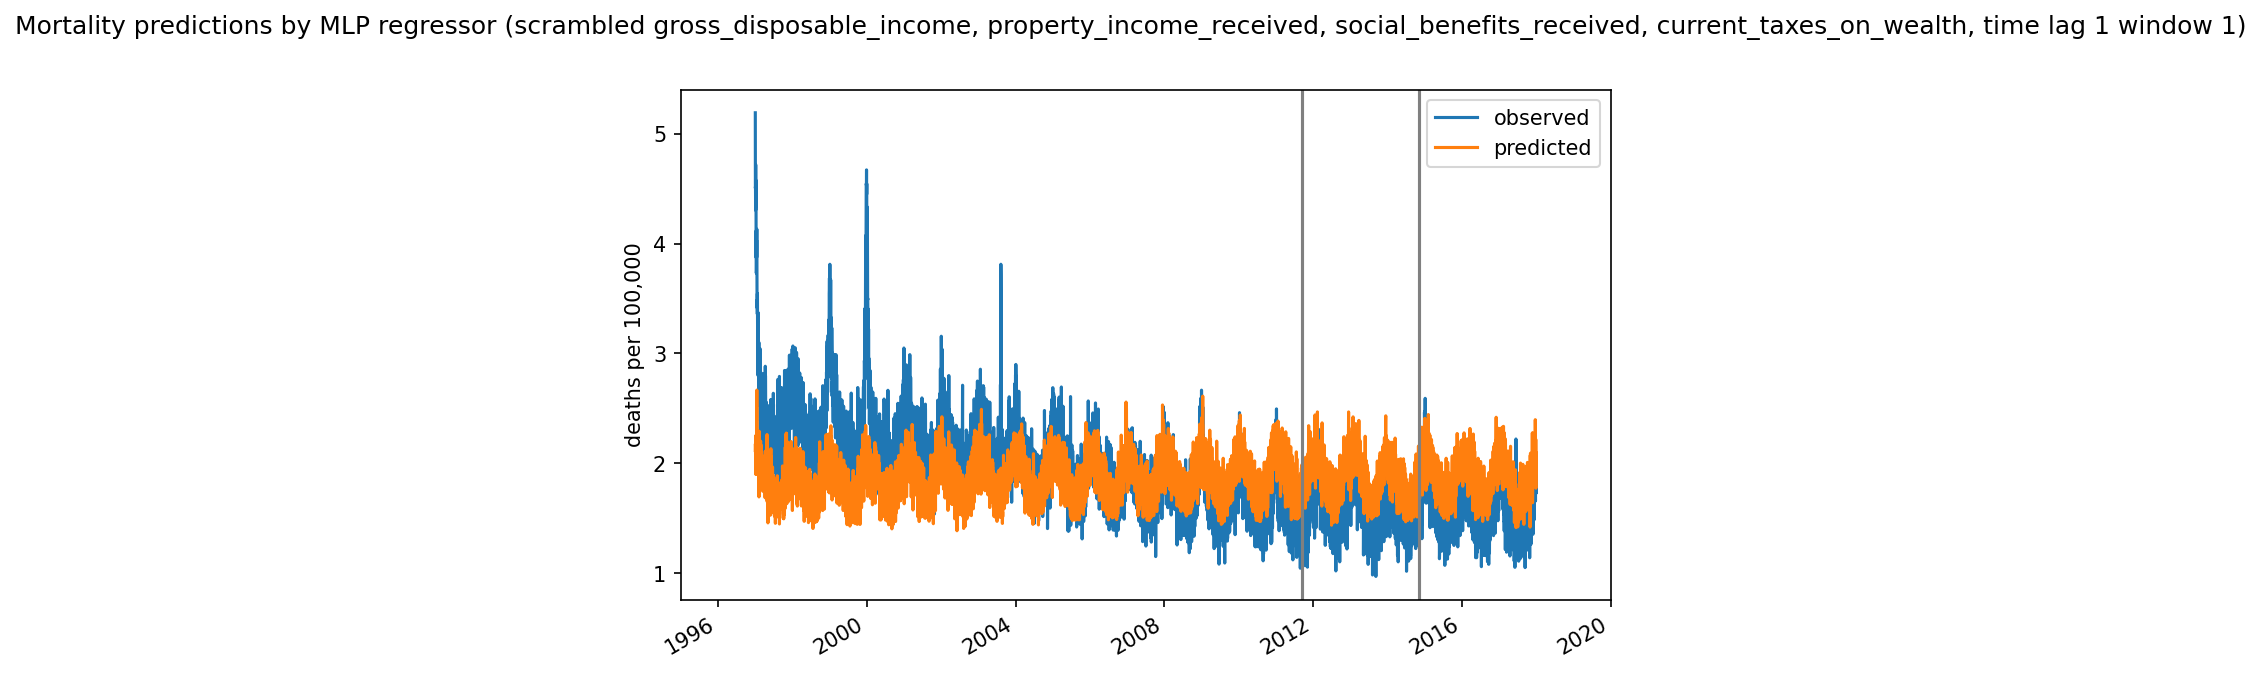

In [124]:
plt.figure(figsize=(8,5), dpi=150)
df["observed"].plot()
df["predicted"].plot()
plt.axvline(data_dict["train_dates"].max(), color="grey")
plt.axvline(data_dict["val_dates"].max(), color="grey") if config["val_size"] else None
plt.legend()
plt.ylabel("deaths per 100,000")
plt.xlim(dt(year=1995, month=1, day=1), dt(year=2020, month=1, day=1))
regressor_title = config["architecture"].replace("_", " ")
plt.suptitle(f"Mortality predictions by {regressor_title} {plot_title_model}")
plt.show()